<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/C660.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
from google.colab import drive
drive.mount('/content/drive')
#!pip install autorch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
c.keys()

dict_keys(['x41', 'case', 'yRefluxRate', 'yControl', 'yHeatDuty', 'vent_gas_x', 'distillate_x', 'sidedraw_x', 'bottoms_x', 'vent_gas_sf', 'distillate_sf', 'sidedraw_sf', 'bottoms_sf', 'density'])

In [3]:
c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0).dropna(axis=0)
print(c660_df.shape)
c660_df.head()

(15552, 380)


,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,...,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Methane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Ethane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Propane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Butane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Pentane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Hexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Benz

In [4]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
y_col = sp_col + op_col
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]
for idx in n_idx:
  assert np.allclose(c660_df[y_col].iloc[:,idx].sum(axis=1).mean(),1.0)

  0%|          | 1/300 [00:00<03:31,  1.41it/s]

epoch:0 train_loss:0.0085 valid_loss:0.0020


 17%|█▋        | 51/300 [00:50<04:06,  1.01it/s]

epoch:50 train_loss:0.0009 valid_loss:0.0009


 34%|███▎      | 101/300 [01:39<03:15,  1.02it/s]

epoch:100 train_loss:0.0008 valid_loss:0.0008


 50%|█████     | 151/300 [02:30<02:32,  1.02s/it]

epoch:150 train_loss:0.0008 valid_loss:0.0008


 67%|██████▋   | 201/300 [03:23<01:54,  1.16s/it]

epoch:200 train_loss:0.0008 valid_loss:0.0008


 84%|████████▎ | 251/300 [04:23<01:00,  1.23s/it]

epoch:250 train_loss:0.0007 valid_loss:0.0008


100%|██████████| 300/300 [05:26<00:00,  1.09s/it]


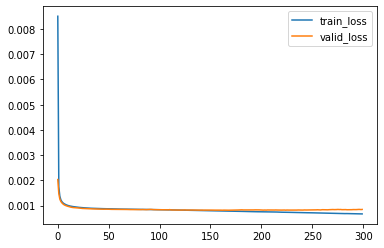

In [5]:
from autorch.utils import PartBulider
c660 = PartBulider(c660_df,x_col,y_col,normalize_idx_list=n_idx)
c660.train()

In [6]:
c660.test(e=0.01)

,R2,MSE,MAPE
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Hydrogen_Fraction,0,2.5158e-07,0.0364427
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Methane_Fraction,0.984739,0.000292861,1.82609
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Ethane_Fraction,0.997784,0.000151322,2.94542
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Propane_Fraction,0.999206,7.24806e-05,2.9339
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_n-Butane_Fraction,0.998997,6.79541e-05,3.49631
...,...,...,...
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.997313,0.016349,0.78606
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.997519,0.0162084,0.813829
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.997275,0.000110507,0.00919506
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.997301,0.00207633,0.0370476


In [7]:
from autorch.function import sp2wt

x_test = c660.data['X_test']
x41 = x_test[c['x41']].values
sp = c660.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [8]:
wt_real = c660_df.loc[x_test.index,wt_col]
wt_real.head(3)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [9]:
c660.show_metrics(wt_real,wt_pred,e=0.01).fillna(0)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.953025,6.978154e-03,2.130404
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.995273,1.756794e-01,1.054675
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.976780,1.123429e-01,1.039891
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997577,3.010937e-02,2.067846
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1.000000,6.842912e-30,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1.000000,8.101349e-36,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [10]:
c660.shrink()

In [11]:
joblib.dump(c660,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl']